# $\delta_F$-vs-$\rho_{DM}$

In [1]:
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter as gf

def get_deltaF_deltam_est(n , z=2.4, fit_deg=2):
    """Estimator for each mock"""
    mockmap = np.fromfile('../LyTomo_data/mock_maps_z'+str(z)+'/map_TNG_z'+str(z)+'_n'+str(n)+'.dat')
    deltaF_mock = np.ravel(gf(mockmap.reshape(205,205,205), 4, mode='wrap'))
    DM = np.ravel(gf(h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:], 4 , mode='wrap'))
    co = np.polyfit(deltaF_mock, DM, fit_deg)
    
    return co

def get_deltaF_deltam_est_noiseless(z=2.4, fit_deg=2):
    """Estimator for each mock"""
    truemap = h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5','r')['map'][:]
    deltaF_true = np.ravel(gf(truemap, 4, mode='wrap'))
    DM = np.ravel(gf(h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:], 4 , mode='wrap'))
    co = np.polyfit(deltaF_true, DM, fit_deg)
    
    return co


def get_deltaF_deltam_mean_std(nmocks=20, z=2.4, fit_deg=1):
    """Get the mean and stdev of the estimator's parameters"""
    co_all = np.empty((nmocks, int(fit_deg+1)))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        co = np.array(get_deltaF_deltam_est(n, z=z, fit_deg=fit_deg))
        co_all[i,:] = co
        
    mean = np.median(co_all, axis=0)
    std = np.std(co_all, axis=0)
    for i in range(fit_deg+1):
        print(str(np.around(mean[i],2))+'+-'+ str(np.around(std[i],2)))
    return mean, std   

In [2]:
print(get_deltaF_deltam_est_noiseless(z=2.2, fit_deg=2))
print(get_deltaF_deltam_est_noiseless(z=2.3, fit_deg=2))
print(get_deltaF_deltam_est_noiseless(z=2.4, fit_deg=2))
print(get_deltaF_deltam_est_noiseless(z=2.6, fit_deg=2))

[10.7995731  -5.90745239  0.97169706]
[ 9.0058834  -5.24415264  0.97195142]
[ 7.19288349 -4.60446085  0.97301203]
[ 6.08106332 -4.05319583  0.97265636]


In [3]:
print(get_deltaF_deltam_mean_std(z=2.3, fit_deg=2))
print(get_deltaF_deltam_mean_std(z=2.4, fit_deg=2))
print(get_deltaF_deltam_mean_std(z=2.6, fit_deg=2))

14.57+-0.62
-4.97+-0.06
0.97+-0.0
(array([14.56817442, -4.96863497,  0.96664919]), array([0.61523481, 0.05739479, 0.00476237]))
11.34+-0.49
-4.59+-0.05
0.97+-0.01
(array([11.33512582, -4.58527569,  0.97371359]), array([0.48889537, 0.05352328, 0.00500886]))
10.15+-0.6
-4.37+-0.05
0.99+-0.0
(array([10.1530904 , -4.37489626,  0.99182931]), array([0.60414784, 0.05022069, 0.00364298]))


Summarizing the estimator for the redshift bins : $ \rm \left(\frac{\rho_{\rm DM}}{\langle \rho_{\rm DM} \rangle}\right)^{sm} = a_2  \ {\delta^{sm}_F}\ {}^2 \ + \ a_1 \ \delta^{sm}_F + a_0 $

|    | $a_2$ | $a_1$ | $a_2$ |
|----|---|---| --- |
| z=2.3 | 14.6 $\pm$ 0.6| -4.97$\pm$ 0.06 | 0.97 $\pm$ 0.00|
| z=2.45 | 11.4 $\pm$ 0.5| -4.59$\pm$ 0.05 | 0.97 $\pm$ 0.01|
| z=2.6 | 10.2 $\pm$ 0.6| -4.37$\pm$ 0.05 | 0.99 $\pm$ 0.00|




The relation changes with redshift. Later here and in [this notbook](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/M0_Mtomo.ipynb) we show this actually does not impact the masses of the watersheds, so one can ignore the redshfit evolution of $\delta_F$-$\rho_{DM}$ relation.


Now, Write the mean and std (2d-hist) of that figure on a file : 

In [7]:
def write_mean_std_hist(z=2.4, nmocks=20):
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    htot1 = np.zeros((nmocks, bins[0].size-1, bins[0].size-1))
    htot2 = np.zeros((nmocks, bins[0].size-1, bins[1].size-1))
    DM = np.ravel(gf(h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:], 4 , mode='wrap'))
    
    for i,n in enumerate(np.arange(1,nmocks+1)):
        mockmap = np.fromfile('../LyTomo_data/mock_maps_z'+str(z)+'/map_TNG_z'+str(z)+'_n'+str(n)+'.dat')
        deltaF_mock = np.ravel(gf(mockmap.reshape(205,205,205), 4, mode='wrap'))
        with h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5','r') as ftrue :
            deltaF_true = np.ravel(gf(ftrue['map'][:], 4, mode='wrap'))
        deltaF_true *= np.std(deltaF_mock)/np.std(deltaF_true)
        h1,_, _ = np.histogram2d(deltaF_mock, deltaF_true, bins=[bins[0],bins[0]], density=True)
        h2, _, _= np.histogram2d(deltaF_mock, DM, bins=bins, density=True)
        
        htot1[i,:,:] = h1
        htot2[i,:,:] = h2
    with h5py.File('../LyTomo_data/plotting_data/df_mock_true_dm_z'+str(z)+'.hdf5','w') as fw:
        fw['df_mock_true/median'] = np.median(htot1, axis=0)
        fw['df_mock_true/std'] = np.std(htot1, axis=0)
        fw['df_dm/median'] = np.median(htot2, axis=0)
        fw['df_dm/std'] = np.std(htot2, axis=0)
    
def write_hist_noiseless(z=2.4):
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    noiseless_map = h5py.File('../LyTomo_data/noiseless_maps/map_TNG_true_1.0_z'+str(z)+'.hdf5','r')['map'][:]
    deltaF_true = np.ravel(gf(noiseless_map, 4, mode='wrap'))
    DM = np.ravel(gf(h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z'+str(z)+'.hdf5','r')['DM/dens'][:], 4 , mode='wrap'))
    h,_, _ = np.histogram2d(deltaF_true, DM, bins=[bins[0],bins[1]], density=True)
    with h5py.File('../LyTomo_data/plotting_data/df_dm_true_z'+str(z)+'.hdf5','w') as fw:
        fw['df_dm'] = h


In [8]:
write_hist_noiseless(z=2.4)

In [12]:
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
import matplotlib

def deltaF_true_mock(fig, ax, z=2.4, nmocks=20, vmin=0.01, vmax=10):
    matplotlib.rc('axes',edgecolor='k')
    
    # Set the axes
    plt.style.use('Notebook.mystyle')
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    
    x = np.arange(-0.4,0.4,0.01)
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    extent = ([bins[0][0], bins[0][-1], bins[0][0], bins[0][-1]], [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
    f = h5py.File('../LyTomo_data/plotting_data/df_mock_true_dm_z'+str(z)+'.hdf5','r')
    keys = ['df_mock_true', 'df_dm']
    for i, k in enumerate(keys):
        hplot = f[k+'/median'][:]
        hplot[hplot < vmin] = vmin
        im = ax[i].imshow(np.rot90(hplot), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), extent = extent[i], aspect='auto' )
        if k=='df_dm':
            axins = inset_axes(ax[i],width="100%", height="100%",  bbox_to_anchor=(0.9,0.5, 0.02, 0.4), bbox_transform=ax[i].transAxes)
            cb_ticks_pos = 'left'
            cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[1e-2,1e-1, 1, 10,100])
            cb.ax.yaxis.set_tick_params(color='k')
            cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
            cb.ax.yaxis.set_label_position(cb_ticks_pos)
            plt.setp(plt.getp(axins, 'yticklabels'), color='w')
            cb.ax.set_ylabel('2-D PDF', labelpad=5, color='w', fontsize=20)

    
    ax[0].set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax[0].set_ylabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, noiseless}}$')
    #ax[1].set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax[1].set_ylabel(r'$\rm  \left(\frac{\rho_{DM}}{ \langle \rho_{DM} \rangle}\right)^{\rm sm}$', fontsize=40)
    ax[1].set_xlim(-0.35,0.25)
    ax[0].set_xlim(-0.35,0.25)
    ax[0].set_ylim(-0.35,0.25)
    ax[1].set_ylim(0,3.5)
    ax[0].set_yticks(ticks = np.arange(-.3,.3,.1))
    ax[0].set_xticks(ticks = np.arange(-.3,.3,.1))
    ax[1].set_xticks(ticks = np.arange(-.3,.3,.1))
    ax[0].plot([-.3,.2],[-.3,.2], label='1:1', color='C1', ls='--')
    ax[0].legend(loc='lower right', facecolor='w')
    ax[1].legend(loc='lower left', fontsize=20, facecolor='w')
    plt.setp(ax[0].get_xticklabels(), rotation=20, fontsize=20)
    
    ax[1].grid(True)
    ax[0].grid(True)
    plt.tight_layout()


No handles with labels found to put in legend.
<ipython-input-12-84c9fab4a464>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


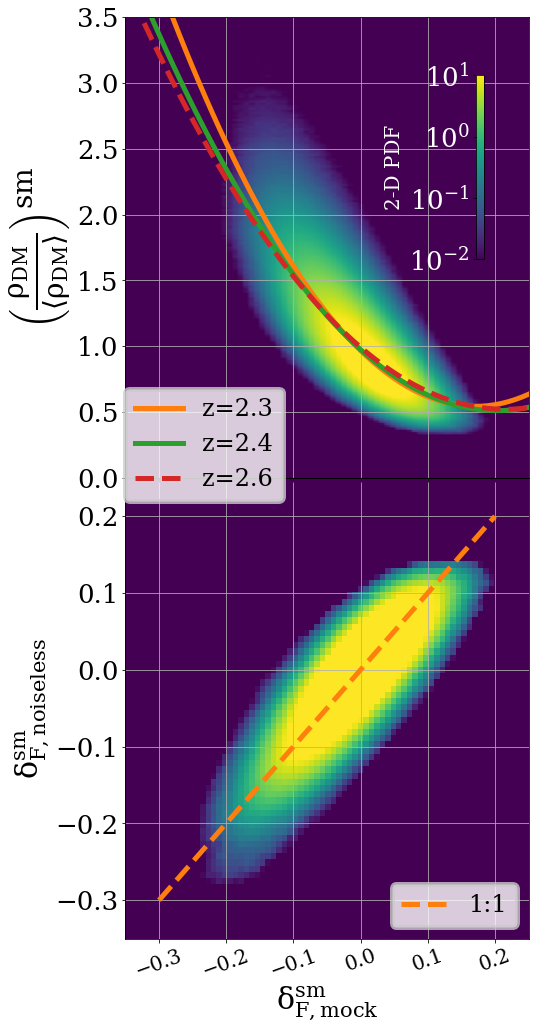

In [14]:
left, width = .2, .7
bottom2, height2 = 0.5, 0.4
bottom1, height1 = .1, .4

rect_scatter1 = [left, bottom1, width, height1]
rect_scatter2 = [left, bottom2, width, height2]

fig = plt.figure(figsize=(8, 16))
ax = []
ax.append(fig.add_axes(rect_scatter1))
ax.append(fig.add_axes(rect_scatter2))
ax[1].tick_params(axis="x", labelbottom=False)
deltaF_true_mock(fig, ax, z=2.4)
x = np.arange(-0.4,0.4,0.01)


ax[1].plot(x, np.polyval([14.56817442, -4.96863497,  0.96664919], x), label='z=2.3', color='C1')
ax[1].plot(x, np.polyval([11.33512582, -4.58527569,  0.97371359],x), label='z=2.4', color='C2')
ax[1].plot(x, np.polyval([10.1530904 , -4.37489626,  0.99182931], x), label='z=2.6', ls='--', color='C3')
ax[1].legend(loc=(0,-.05), facecolor='w')
fig.savefig('./figures/deltam_deltaF_z2.4.pdf', transparent=False)

In the noiseless map :

In [29]:
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from scipy.ndimage import gaussian_filter
import matplotlib

def deltaF_true_mock_noiseless(fig, ax, z=2.4, vmin=0.01):
    matplotlib.rc('axes',edgecolor='k')
    
    # Set the axes
    plt.style.use('Notebook.mystyle')
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    
    x = np.arange(-0.4,0.4,0.01)
    bins=[np.linspace(-.4,.4,100), np.linspace(0,3.5,200)]
    extent = ([bins[0][0], bins[0][-1], bins[0][0], bins[0][-1]], [bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])
    f = h5py.File('../LyTomo_data/plotting_data/df_dm_true_z'+str(z)+'.hdf5','r')
    hplot = f['df_dm'][:]
    hplot[hplot < vmin] = vmin
    im = ax.imshow(np.rot90(hplot), cmap=plt.cm.viridis, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=10), extent = extent[1], aspect='auto' )
    axins = inset_axes(ax,width="100%", height="100%",  bbox_to_anchor=(0.9,0.5, 0.02, 0.4), bbox_transform=ax.transAxes)
    cb_ticks_pos = 'left'
    cb = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[1e-2,1e-1, 1, 10,100])
    cb.ax.yaxis.set_tick_params(color='k')
    cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
    cb.ax.yaxis.set_label_position(cb_ticks_pos)
    plt.setp(plt.getp(axins, 'yticklabels'), color='w')
    cb.ax.set_ylabel('2-D PDF', labelpad=5, color='w', fontsize=20)

    
    ax.set_xlabel(r'$\mathrm{\delta^{\rm sm}_{\rm F, mock}}$')
    ax.set_ylabel(r'$\rm  \left(\frac{\rho_{DM}}{ \langle \rho_{DM} \rangle}\right)^{\rm sm}$', fontsize=40)
    ax.set_xlim(-0.35,0.25)
    ax.set_ylim(0,3.5)
    ax.set_xticks(ticks = np.arange(-.3,.3,.1))
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=20)
    
    ax.grid(True)
    plt.tight_layout()


<ipython-input-29-e55f3b3388a5>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


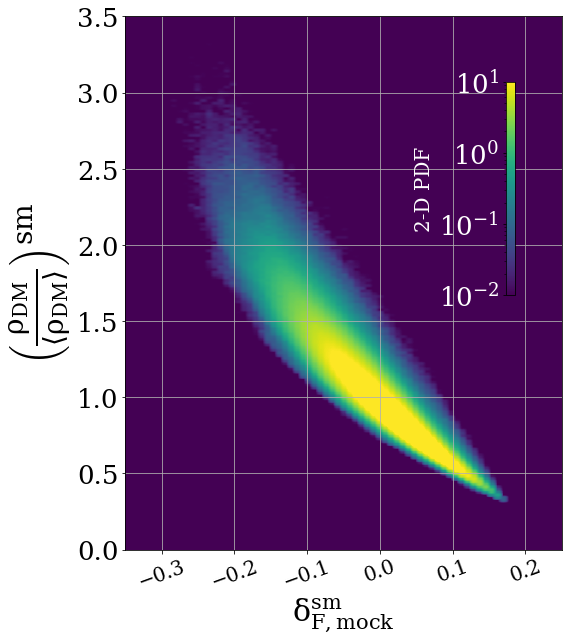

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8, 9))
deltaF_true_mock_noiseless(fig, ax, z=2.4)
x = np.arange(-0.4,0.4,0.01)

fig.savefig('./figures/deltam_deltaF_z2.4_noiseless_map.pdf', transparent=False)

# $M_{DM}$-vs-$M_{tomo}$:

Now, we check  whether the DM mass estimation of the wtaersheds is effected if we only use the  $\delta_F$-vs-$\rho_{DM}$ relation at z=2.4 for all other redshifts. 




In [11]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import importlib
plt.style.use('paper.mystyle')

def find_optimal_offset(ax, Mtomo, MDM, ls, label):
    offset_range = np.arange(0,1,0.0001)
    err = np.array([])
    for offset in offset_range:
        dev = MDM - (Mtomo+offset)
        err = np.append(err, np.sqrt(np.mean(dev*dev)))
    ind = np.where(err == np.min(err))
    print('Minimum error is at offset = ', offset_range[ind])
    ax.plot(offset_range, err, ls=ls, label=label)

    
    
def get_id_max_overlap(lmap_mock, lmap_true):
    """returns : A dictionary of the corresponding ids of overlapping structures, 
    just returns those structures which have overlapping structures in true map"""
    minima_mock = np.unique(lmap_mock)
    minima_true = np.unique(lmap_true)
    minima_mock = np.delete(minima_mock, np.where(minima_mock==0))
    minima_true = np.delete(minima_true, np.where(minima_true==0))
    
    
    id_max_overlap = {'mock':np.array([]),'true':np.array([])}
    for i in minima_mock:
        indm = np.where(lmap_mock==i)
        idtrue, counts = np.unique(lmap_true[indm], return_counts=True)
        if idtrue[0] == 0:
            idtrue = np.delete(idtrue, 0)
            counts = np.delete(counts, 0)
            if counts.size== 0 :
                continue
        counts_sorted = np.sort(counts)
        # Here, If 2 sub-contours overlap identically, we pick just the one with lower id
        indt = np.where(counts == counts_sorted[-1])[0][0]
        if idtrue[indt]!=0 :
            id_max_overlap['mock'] = np.append(id_max_overlap['mock'], i)
            id_max_overlap['true'] = np.append(id_max_overlap['true'], idtrue[indt])
    id_max_overlap['true'].astype(int); id_max_overlap['mock'].astype(int)
    return id_max_overlap

def get_MDM(n=1, z=2.4, th=2.35, lc=2.0, conversion_not_adjusted=False):
    """Returns Mtomo and DM mass within the mock watersheds and the companion ones
    in the nosieless map"""
    import importlib
    from codes import minima
    importlib.reload(minima)
    if conversion_not_adjusted:
        with h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)
                       +'/labeled_map_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'
                       +str(np.around(th,2)).ljust(4,'0')+'_lc'
                       +str(np.around(lc,2)).ljust(4,'0')
                       +'_conversion_not_adjusted.hdf5','r') as f:
            lmap_mock = f['map'][:]
        peaks_mock = h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'
                               +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                               +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                               +'_lc'+str(np.around(lc,2)).ljust(4,'0')
                               +'_conversion_not_adjusted.hdf5', 'r')
    else:
        with h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)
                       +'/labeled_map_TNG_z'+str(z)+'_n'+str(n)
                       +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                       +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r') as f:
            lmap_mock = f['map'][:]
        peaks_mock = h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'
                               +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                               +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                               +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')
    with h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/noiseless/labeled_map_TNG_true_z'
                   +str(z)+'_n1_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'
                   +str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r') as f :
        lmap_true = f['map'][:]
    peaks_true = h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/noiseless/peaks_TNG_true_z'
                           +str(z)+'_n1_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                           +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r')

    DM = h5py.File('../LyTomo_data/DM_Density_field/TNG_DM_z'
                   +str(z)+'.hdf5','r')['DM/dens'][:]
    z_accurate = h5py.File('../LyTomo_data/spectra_z'+str(z)
                           +'/spectra_TNG_z'+str(z)+'_n1.hdf5','r')['Header'].attrs['redshift']
    
    DM *= minima.convert_Delta_Msol_ph(z=z_accurate)
    MDM_true = np.array([])
    MDM_mock = np.array([])
    MDM_mock_true = np.array([])
    for i in range(1, peaks_mock['mtomo'].size+1):
        ind = np.where(lmap_mock == i)
        MDM_mock = np.append(MDM_mock, np.log10(np.sum(DM[ind])))
    for i in range(1, peaks_true['mtomo'].size+1):
        ind = np.where(lmap_true == i)
        MDM_true = np.append(MDM_true, np.log10(np.sum(DM[ind])))
    
    id_max_overlap = get_id_max_overlap(lmap_mock=lmap_mock, lmap_true=lmap_true)
    for i in id_max_overlap['true'][:]:
        ind = np.where(lmap_true==i)
        MDM_mock_true = np.append(MDM_mock_true, np.log10(np.sum(DM[ind])))
    return peaks_mock['mtomo'][:], peaks_true['mtomo'][:], MDM_mock, MDM_true, MDM_mock_true, id_max_overlap


In [54]:
def write_data(z=2.4, th=2.35, lc=2.00, offset=0.114, conversion_not_adjusted=False):
    """Writes the Mtomo and Dm masses on a file since they are slow to produce"""
    if conversion_not_adjusted:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'+str(z)+'_th'+str(th).ljust(4,'0')
                 +'_lc'+str(lc).ljust(4,'0')+'_conversion_not_adjusted.hdf5')
    else:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'+str(z)+'_th'
                 +str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')+'.hdf5')
    with h5py.File(fname,'w') as fw:
        for n in range(1,21):
            Mtomo_mock, Mtomo_true, MDM_mock, MDM_true, MDM_mock_true, id_max_overlap = get_MDM(n=n, z=z, th=th, lc=lc)
            fw[str(n)+'/Mtomo_mock'] = Mtomo_mock[:]+offset
            fw[str(n)+'/MDM_mock'] = MDM_mock[:]
            fw[str(n)+'/Mtomo_mock_overlap'] = Mtomo_mock[:][id_max_overlap['mock'][:].astype(int)-1]+offset
            fw[str(n)+'/MDM_true_overlap'] = MDM_mock_true
            fw[str(n)+'/id_max_overlap/mock'] = id_max_overlap['mock'][:]
            fw[str(n)+'/id_max_overlap/true'] = id_max_overlap['true'][:]

Few methods to find the best power-law estimator and the error around them. It divides the 20 mocks into 16 mocks for training and 4 mocks for testing (fidning the uncertainties). 

In [10]:
def make_a_pool(nrange, z=2.4, th=2.35, lc=2.00, conversion_not_adjusted=False):
    """Make a pool of all strucutres in all mocks"""
    Mtomo = np.array([])
    MDM = np.array([])
    if conversion_not_adjusted:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'
                 +str(z)+'_th'+str(th).ljust(4,'0')+'_lc'
                 +str(lc).ljust(4,'0')+'_conversion_not_adjusted.hdf5')
    else:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'
                 +str(z)+'_th'+str(th).ljust(4,'0')
                 +'_lc'+str(lc).ljust(4,'0')+'.hdf5')
        
    f = h5py.File(fname,'r')
    for n in nrange:
        Mtomo = np.append(Mtomo, f[str(int(np.around(n)))+'/Mtomo_mock_overlap'][:])
        MDM = np.append(MDM, f[str(int(np.around(n)))+'/MDM_true_overlap'][:])

    # Randomize the pool
    ind_rnd = np.random.choice(np.arange(Mtomo.size), size= Mtomo.size, replace=False)
    Mtomo = Mtomo[ind_rnd]
    MDM = MDM[ind_rnd]

    return Mtomo, MDM


def plot_different_fits(train_size=16, z=2.4, th=2.35, lc=2.00, 
                        conversion_not_adjusted=False):
    
    import scipy.stats
    from scipy.stats import linregress
    
    fig, ax = plt.subplots(figsize=(5,5))
    x = np.arange(13,16.5, 1)
    if conversion_not_adjusted:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'
                 +str(z)+'_th'+str(th).ljust(4,'0')+'_lc'
                 +str(lc).ljust(4,'0')+'_conversion_not_adjusted.hdf5')
    else:
        fname = ('../LyTomo_data/plotting_data/Mtomo_MDM_z'
                 +str(z)+'_th'+str(th).ljust(4,'0')+'_lc'
                 +str(lc).ljust(4,'0')+'.hdf5')
    f = h5py.File(fname,'r')

    slopes = []
    intercepts = []
    ntrain = np.random.choice(np.arange(1,21), size= train_size, replace=False)
    y = np.zeros((train_size, x.size))
    for i, n in enumerate(ntrain):
        Mtomo_mock = f[str(n)+'/Mtomo_mock_overlap'][:]
        co = linregress(Mtomo_mock[:] - 14, f[str(n)+'/MDM_true_overlap'][:])
        slopes.append(co[0])
        intercepts.append(co[1])
        ax.plot(x, co[0]*(x-14)+co[1], alpha=0.7, lw=1)
        y[i] = co[0]*(x-14)+co[1]
    mean = np.mean(y, axis=0)
    #ax.plot(x, mean, lw=4)
    std = np.std(y, axis=0)
    
    slope_mean = np.mean(slopes)
    intercept_mean = np.mean(intercepts)
    print('Slope : ', str(slope_mean)[:5]+'+-'+str(np.std(slopes))[:5])
    print('Intercept : ', str(intercept_mean)[:5]+'+-'+str(np.std(intercepts))[:5])
    ax.fill_between(x=x, y1=mean-std, y2=mean+std, color='C3', alpha=0.4, edgecolor='None')
    
    
    ax.set_xlim((13,16))
    ax.set_ylim((13,16))
    ax.set_xlabel(r'$\mathrm{M_{tomo, mock}}$')
    ax.set_ylabel(r'$\mathrm{M_{DM, noiseless}}$')
    
    return ntrain, (intercept_mean, slope_mean)

def test_fit(co, ntest, z=2.4, th=2.35, lc=2.00, bins=np.array([13, 14, 14.5, 15.5]),
             conversion_not_adjusted=False):
    """Find the errors for in mass bins of bins for the mock maps array of ntest"""
    
    fit = lambda x : co[1]*(x-14) +co[0]
    Mtomo, MDM = make_a_pool(ntest,z=z, th=th, lc=lc, conversion_not_adjusted=conversion_not_adjusted)
    
    err = []
    for i in range(bins.size-1):
        ind = np.where( (Mtomo > bins[i])*(Mtomo < bins[i+1]))
        dev = fit(Mtomo[ind]) - MDM[ind]
        err.append(np.sqrt(np.sum(dev*dev)/dev.size))
    
    return err

Few functions to get the mean KDE of MDM-Mtomo realtion in the 20 mock maps.

In [17]:
def get_kde(M1, M2, mmin= 13, mmax= 16):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)  
    X, Y = np.mgrid[mmin:mmax:50j, mmin:mmax:50j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z

def get_mean_KDE(z, th, lc, nmocks=20, first_plot=True):
    import os
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
    f = h5py.File(os.path.join(data_dir,'plotting_data/Mtomo_MDM_z'+str(z)
                  +'_th'+str(th).ljust(4,'0')+'_lc'+str(lc).ljust(4,'0')
                  +'.hdf5'),'r')
    Zall = []
    if first_plot:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:]))
    else:
        for n in np.arange(1,nmocks+1):
            Zall.append(get_kde(f[str(n)+'/Mtomo_mock_overlap'][:], 
                                f[str(n)+'/MDM_true_overlap'][:]))
    f.close()
    
    Zmean = np.zeros(shape=(50,50))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    
    return Zmean
        

In [26]:
def plot_Mtomo_MDM(fig, ax, Mtomo, MDM, z, th, lc, signif=None, linear_transform=False, title='', xlabel=r'$\rm log[M_{tomo}]$',  ylabel=r'$\rm log[M_{DM, noiseless}]$',
                   data_for_Drew=None, co=None, legend=True, plot_kde=False, first_plot=True, vmin=0.01, vmax=1):
    
    import scipy.stats
    from scipy.stats import linregress
    
    mmin, mmax = 13, 16
    ax.plot([13,16],[13,16], alpha=0.4, color='r', label='1:1', ls='--', lw=8)
    
    if plot_kde :
        
        Z = get_mean_KDE(z=z, th=th, lc=lc, first_plot=first_plot)
        #Z[Z < 0.01*vmin] = 0.01*vmin
        im = ax.imshow(np.rot90(Z), cmap=plt.cm.viridis,extent = [mmin, mmax, mmin, mmax] )
        cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.25, shrink=0.7)
        
        cb.ax.set_xlabel('Gaussian KDE')
    
    if co is None:
        co = linregress(Mtomo-14, MDM)
        #print('fitting line :', co)
    if linear_transform:
        Mtomo *= co[0]
        Mtomo += co[1]
    else :
        x = np.array([13-14,16])
        ax.plot(x, co[0]*(x-14)+co[1], alpha=0.7, label='power-law estimator',ls='dotted', lw=8)

    if signif is None :
        ax.scatter(Mtomo, MDM, alpha=0.3)
    else :
        ind1 = (signif > -2.5)*(signif < -2.35)
        ind2 = (signif > -3.0)*(signif < -2.5)
        ind3 = (signif > -3.5)*(signif < -3.0)
        ind4 = (signif < -3.5)
        ax.scatter( Mtomo[ind1], MDM[ind1], alpha=0.6, label=r'$-2.5 < \sigma < -2.35$',
                   s=50, facecolor='None', edgecolor='r', marker='^', lw=2)
        ax.scatter( Mtomo[ind2], MDM[ind2], alpha=0.65, label=r'$-3.0 < \sigma < -2.5$',
                   s=50, facecolor='None', edgecolor='C1', marker='s', lw=2)
        ax.scatter( Mtomo[ind3], MDM[ind3], alpha=0.6, label=r'$-3.5 < \sigma < -3.0$',
                   s=50, facecolor='None', edgecolor='violet', marker='o', lw=2)
        ax.scatter( Mtomo[ind4], MDM[ind4], alpha=0.6, label=r'$ \sigma < -3.5 $', s=50,
                   facecolor='None', edgecolor='w', marker='D', lw=2)
        
        if data_for_Drew is not None:
            fw = h5py.File(data_for_Drew, 'w')
            fw['Mtomo'] = Mtomo
            fw['MDM'] = MDM
            fw['signif'] = signif
    
    bins = [13,14,14.5,15.5]
    std = []
    co = [co[0], co[1]]
    for b in range(1,len(bins)):
        ind = np.where((Mtomo[:] > bins[b-1])*(Mtomo[:] < bins[b]))
        #print('diff = ', MDM[ind] - Mtomo[ind])
        dev = MDM[ind] - np.polyval(co, Mtomo[ind])
        #print('dev = ', dev)
        std.append(np.sqrt(np.mean(dev*dev)))
    #print('RMS scatter around the fit in bins of ', bins, ' are :', std)
    dev = MDM - np.polyval(co, Mtomo)
    #print(' The total RMS scatter around the fit is : ', np.sqrt(np.mean(dev*dev)))
        
    ax.set_xlim((13,16))
    ax.set_ylim((13,16))
    ax.set_xticks(np.arange(13.5,16,.5))
    ax.set_yticks(np.arange(13.5,16,.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.7)
    ax.set_title(title)
    if legend:
        ax.legend( framealpha=1, loc=(1.05, 0.2), fontsize=18, facecolor='gray',
                  frameon=True)        
    plt.setp(ax.get_xticklabels(), rotation=40)

In [5]:
def plot_for_paper(n, z, th, lc, co=(0.40,14.50), vmin=0.01, vmax=1e2, 
                   conversion_not_adjusted=False):
    """plot the M_DM vs M_tomo for paper"""
    import os
    data_dir = '/run/media/mahdi/HD2/Lya/LyTomo_data/'
    if conversion_not_adjusted:
        fname = os.path.join(data_dir, 'plotting_data/Mtomo_MDM_z'
                             +str(z)+'_th'+str(th).ljust(4,'0')+'_lc'
                             +str(lc).ljust(4,'0')+'_conversion_not_adjusted.hdf5')
        
        signif = h5py.File(os.path.join(data_dir, 'watersheds_z'+str(z)+'/mocks/n'
                                        +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                                        +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                                        +'_lc'+str(np.around(lc,2)).ljust(4,'0')
                                        +'_conversion_not_adjusted.hdf5'), 'r')['signif'][:]
    else :
        fname = os.path.join(data_dir,'plotting_data/Mtomo_MDM_z'
                             +str(z)+'_th'+str(th).ljust(4,'0')+'_lc'
                             +str(lc).ljust(4,'0')+'.hdf5')
        
        signif = h5py.File(os.path.join(data_dir,'watersheds_z'+str(z)+'/mocks/n'
                                        +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                                        +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                                        +'_lc'+str(np.around(lc,2)).ljust(4,'0')
                                        +'.hdf5'), 'r')['signif'][:]
        
    f = h5py.File(fname,'r')
    fig, ax = plt.subplots(1,2, figsize=(18,9))


    
    plot_Mtomo_MDM(fig, ax[0], f[str(n)+'/Mtomo_mock'][:], f[str(n)+'/MDM_mock'][:],
                   z=z, th= th, lc=lc, signif=signif,xlabel=r'$\rm log [ M_{tomo} ]$',
                   ylabel=r'$\rm log [ M_{DM, mock}]$', legend=False, plot_kde=True, 
                   first_plot=True, vmin=vmin, vmax=vmax)

    #signif = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)+'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')+'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')['signif'][:]
    signif = signif[f[str(n)+'/id_max_overlap/mock'][:].astype(int)-1]

    plot_Mtomo_MDM(fig, ax[1], f[str(n)+'/Mtomo_mock_overlap'][:],
                   f[str(n)+'/MDM_true_overlap'][:], z=z, th=th, 
                   lc=lc, signif=signif, co=co, legend=True, 
                   plot_kde=True, first_plot=False)
    
    f.close()
    plt.tight_layout(pad=0)
    return fig

## For $z=2.3, 2.4, 2.6$ and $\nu = -2.0$, $\kappa = -2.35$ :

### Find optimal offset in $M_{tomo}$:
First, we need to find the best offset introduced in equation 7 in [the paper](https://arxiv.org/pdf/2112.03930.pdf).

Find the optimal offset needed to get the Mtomo close to MDM within same waterhseds in mock maps.

In [66]:
def get_offset(conversion_not_adjusted=True):
    z, ls= [2.3,2.4, 2.6], ['--', 'solid', 'dotted']
    fig, ax = plt.subplots()
    ax.set_xlabel('offset (dex)')
    ax.set_ylabel(r'$rms \[ M_{tomo, raw} - M_{DM, mock}]$')
    for i in range(3):
        if i==1:
            Mtomo_mock, _, MDM_mock, _, _, _ = get_MDM(n=1, z=z[i], th=2.35, lc=2.00)
        else:
            Mtomo_mock, _, MDM_mock, _, _, _ = get_MDM(n=1, z=z[i], th=2.35, lc=2.00,
                                                       conversion_not_adjusted=conversion_not_adjusted)
        find_optimal_offset(ax, Mtomo_mock, MDM_mock, ls=ls[i], label='z='+str(z[i]))
    if conversion_not_adjusted:
        ax.set_title('Same '+r'$\delta_F -vs- \rho_{DM}$'+' relation')
    else:
        ax.set_title('Varying '+r'$\delta_F -vs- \rho_{DM}$'+' relation')
    ax.legend()

Minimum error is at offset =  [0.1318]
Minimum error is at offset =  [0.1142]
Minimum error is at offset =  [0.1043]
Minimum error is at offset =  [0.1112]
Minimum error is at offset =  [0.1142]


No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
Font 'rm' does not have a glyph for '\\[' [U+3f], substituting with a dummy symbol.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
Font 'rm' does not have a glyph for '\\[' [U+3f], substituting with a dummy symbol.


Minimum error is at offset =  [0.1105]


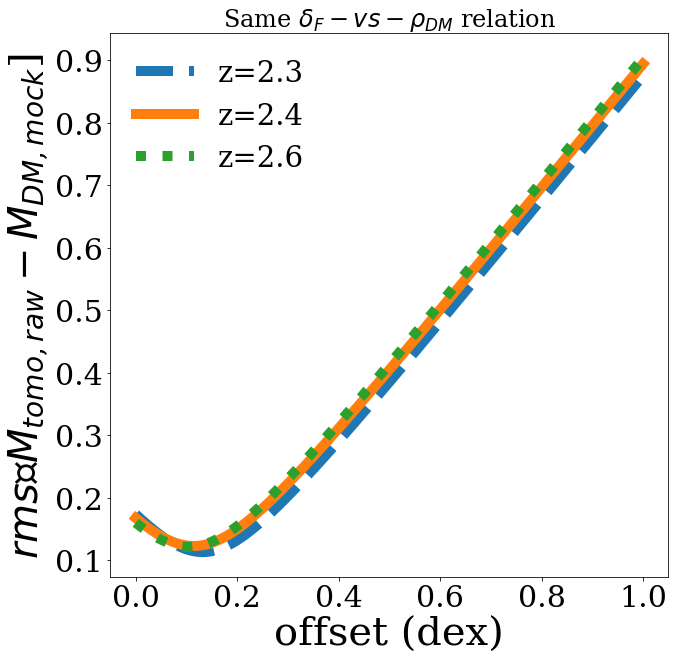

No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
Font 'rm' does not have a glyph for '\\[' [U+3f], substituting with a dummy symbol.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
No TeX to unicode mapping for '\\['.
Font 'rm' does not have a glyph for '\\[' [U+3f], substituting with a dummy symbol.


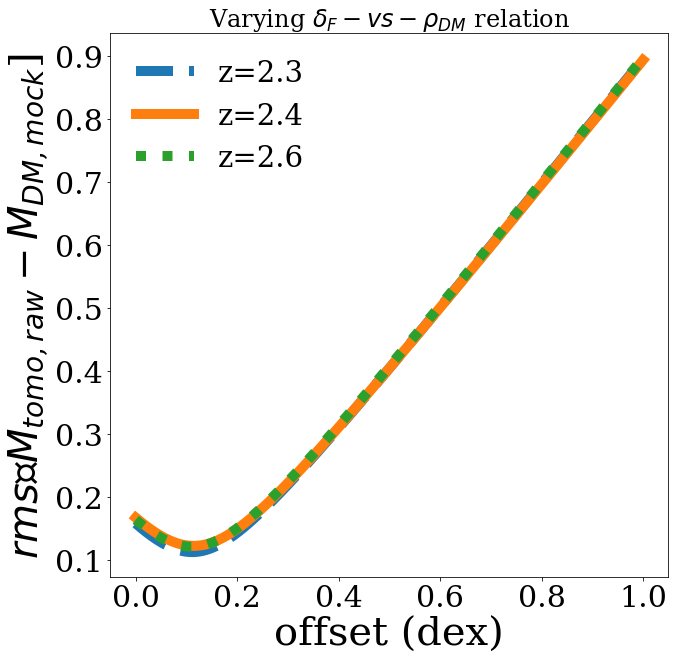

In [67]:
get_offset(conversion_not_adjusted=True)
get_offset(conversion_not_adjusted=False)

- The offset (0.114 dex) is insensitive to the variations in $\delta_F$-vs-$\rho_{DM}$ estimator. 

Write the data on file for later ease. It stores the $M_{tomo}$ and $M_{DM}$ for 20 of mock maps.

**Note** : Each line in the cell below takes ~ 3 minutes to run, so it is a bit slow. \
The data already exists in `./LyTomo_data/plotting_data/`, so if you wish, you can skip running the next cell.

In [47]:
write_data(z=2.3, th=2.35, lc=2.00, offset=0.114,conversion_not_adjusted=False)
write_data(z=2.3, th=2.35, lc=2.00, offset=0.114,conversion_not_adjusted=True)
write_data(z=2.6, th=2.35, lc=2.00, offset=0.114,conversion_not_adjusted=False)
write_data(z=2.6, th=2.35, lc=2.00, offset=0.114,conversion_not_adjusted=True)
write_data(z=2.4, th=2.35, lc=2.00, offset=0.114)

Below we find the mean power-law estimators and comapre the $M_{tomo}$ with $M_{DM}$. \
For z=2.3 and z=2.6, we show the results are insensitive to whetehr we use same \
$\delta_F$-vs-$\rho_{DM}$ estimator found at z=2.4 for other 2 redshifts.


### z=2.3 :

Mean estimator:

Find the mean power-law estimator among the 20 mock maps. 

Slope :  0.434+-0.085
Intercept :  14.54+-0.054
[0.3876812203869685, 0.3802612652783179, 0.3250509215353358]
Slope :  0.438+-0.073
Intercept :  14.54+-0.050
[0.3654404848092256, 0.37122268138755316, 0.32767121354425754]


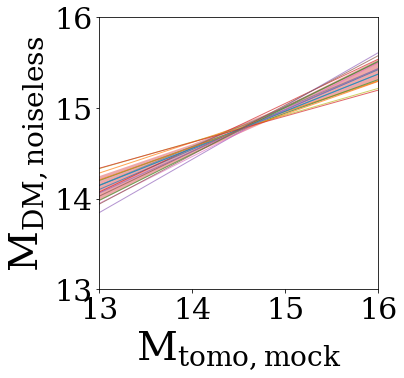

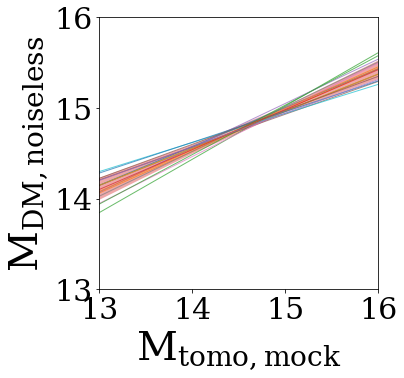

In [68]:
for conversion_not_adjusted in [False, True]:
    ntrain, co = plot_different_fits(z=2.3, th=2.35, lc=2.00,
                                     conversion_not_adjusted=conversion_not_adjusted)
    ntest = np.arange(1,21)[np.in1d(np.arange(1,21), 
                                    ntrain, invert=True)]
    print(test_fit(co, ntest,z=2.3, th=2.35, lc=2.00,
                   conversion_not_adjusted=conversion_not_adjusted))

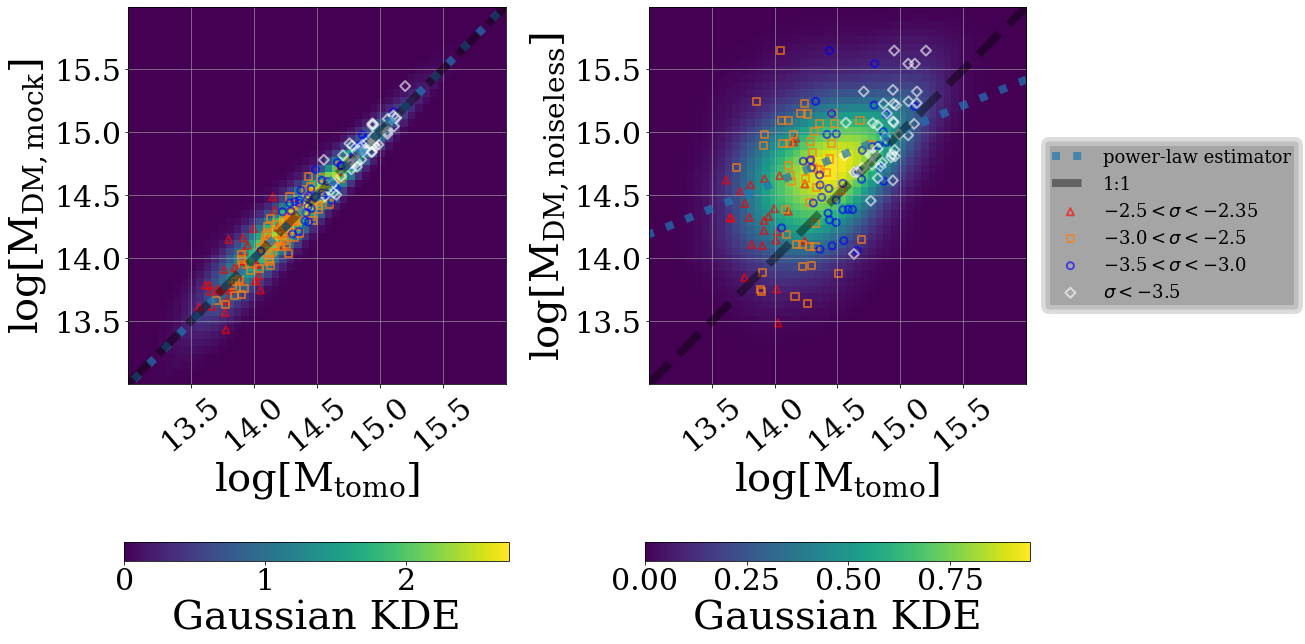

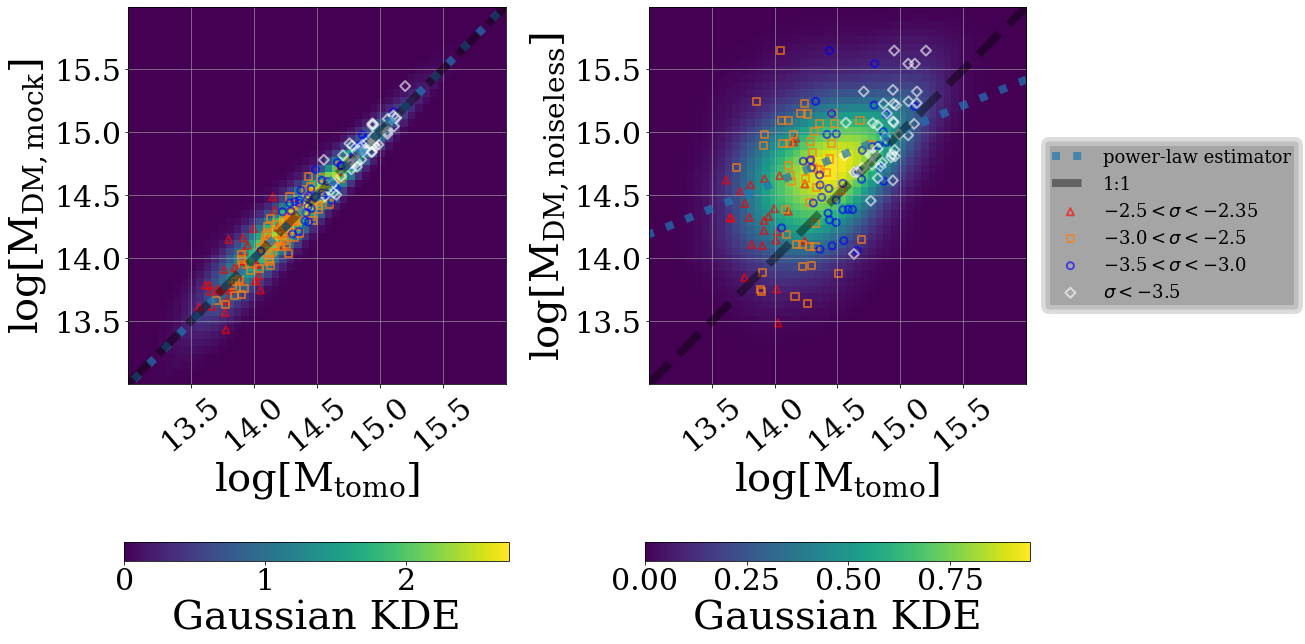

In [69]:
fig = plot_for_paper(n=1, z=2.3, th=2.35, lc=2.00, co=(0.41,14.60), vmin=0.2, vmax=1, conversion_not_adjusted=False)
fig = plot_for_paper(n=1, z=2.3, th=2.35, lc=2.00, co=(0.41,14.60), vmin=0.2, vmax=1, conversion_not_adjusted=True)

### z = 2.4:

Mean estimator:

Slope :  0.379+-0.066
Intercept :  14.54+-0.041


[0.34154119397895166, 0.3436472210234777, 0.2795374654869831]

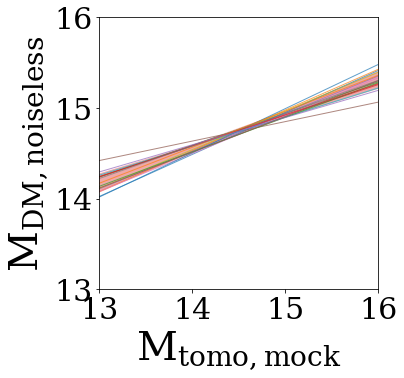

In [70]:
ntrain, co = plot_different_fits(z=2.4, th=2.35, lc=2.00)
ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
test_fit(co, ntest,z=2.4, th=2.35, lc=2.00)

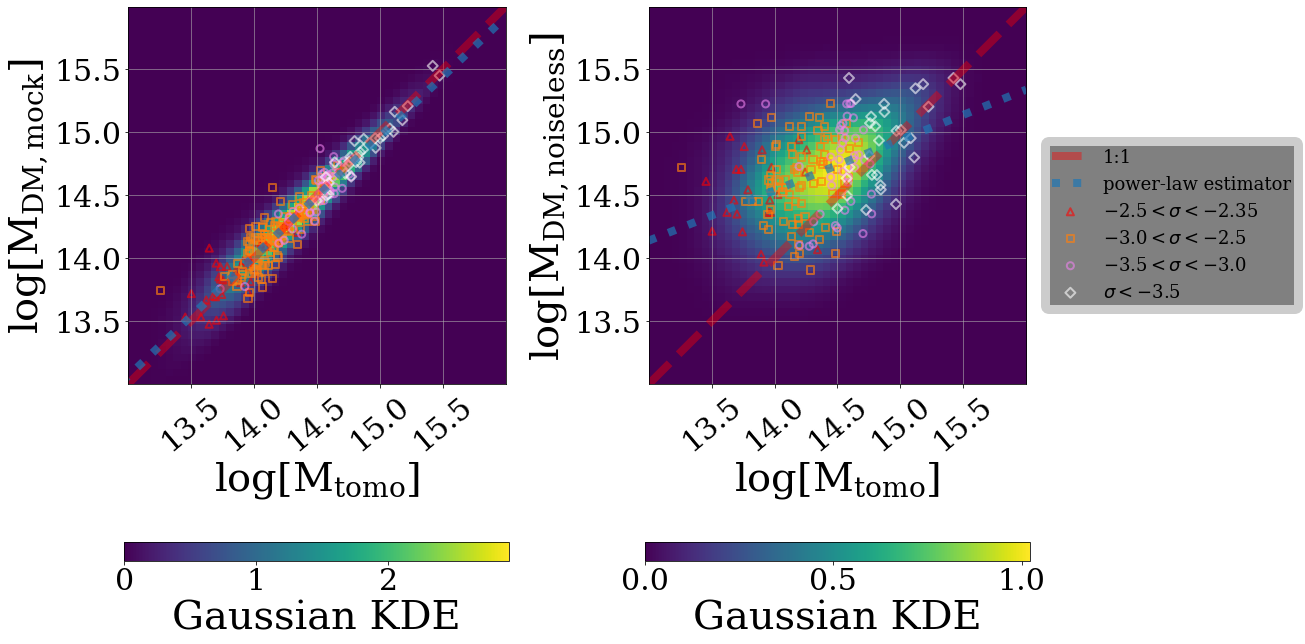

In [27]:
fig = plot_for_paper(n=1, z=2.4, th=2.35, lc=2.00, co=(0.40,14.54), vmin=0.2, vmax=1)
fig.savefig('./figures/Mtomo_mock_MDM_true_kde.pdf')

### z=2.6:
Mean estimator :

Slope :  0.341+-0.051
Intercept :  14.58+-0.032
[0.35997959924773376, 0.31979869762645013, 0.3041397490873407]
Slope :  0.344+-0.048
Intercept :  14.57+-0.030
[0.362965328869551, 0.34396106102062923, 0.3042764853657085]


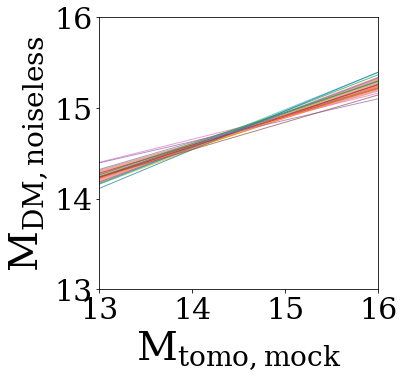

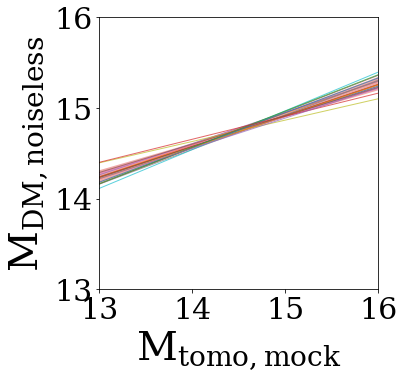

In [73]:
for conversion_not_adjusted in [False, True]:
    ntrain, co = plot_different_fits(z=2.6, th=2.35, lc=2.00, 
                                     conversion_not_adjusted=conversion_not_adjusted)
    ntest = np.arange(1,21)[np.in1d(np.arange(1,21), ntrain, invert=True)]
    print(test_fit(co, ntest,z=2.6, th=2.35, lc=2.00, 
                   conversion_not_adjusted=conversion_not_adjusted))

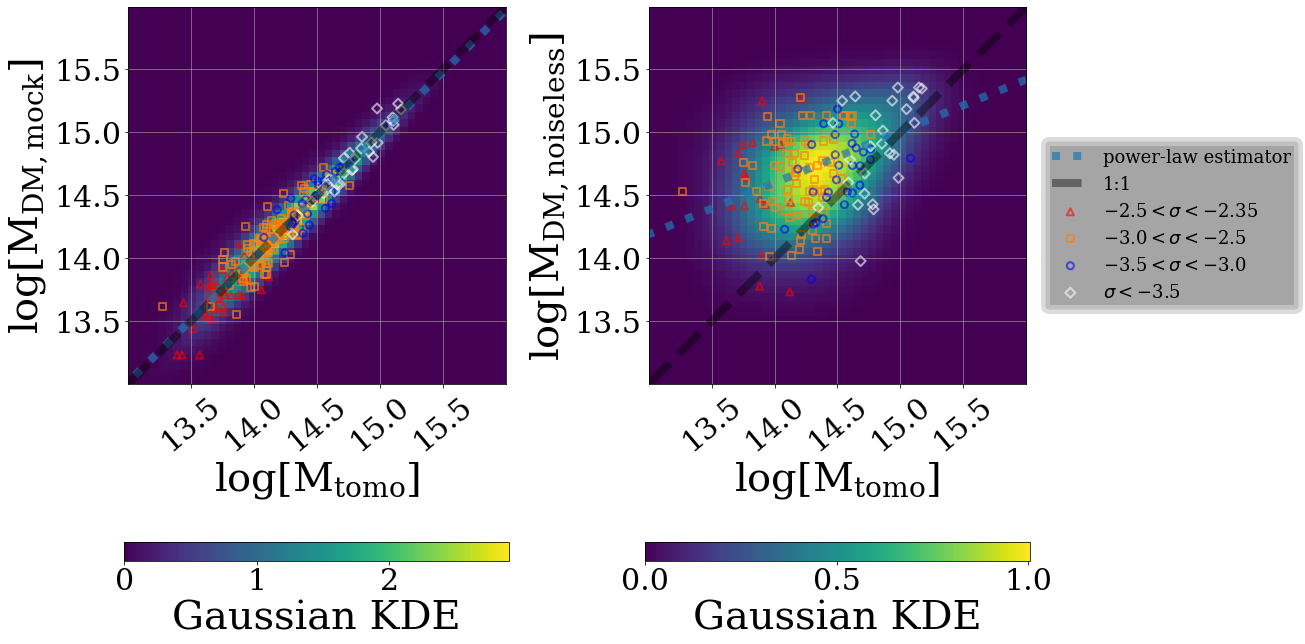

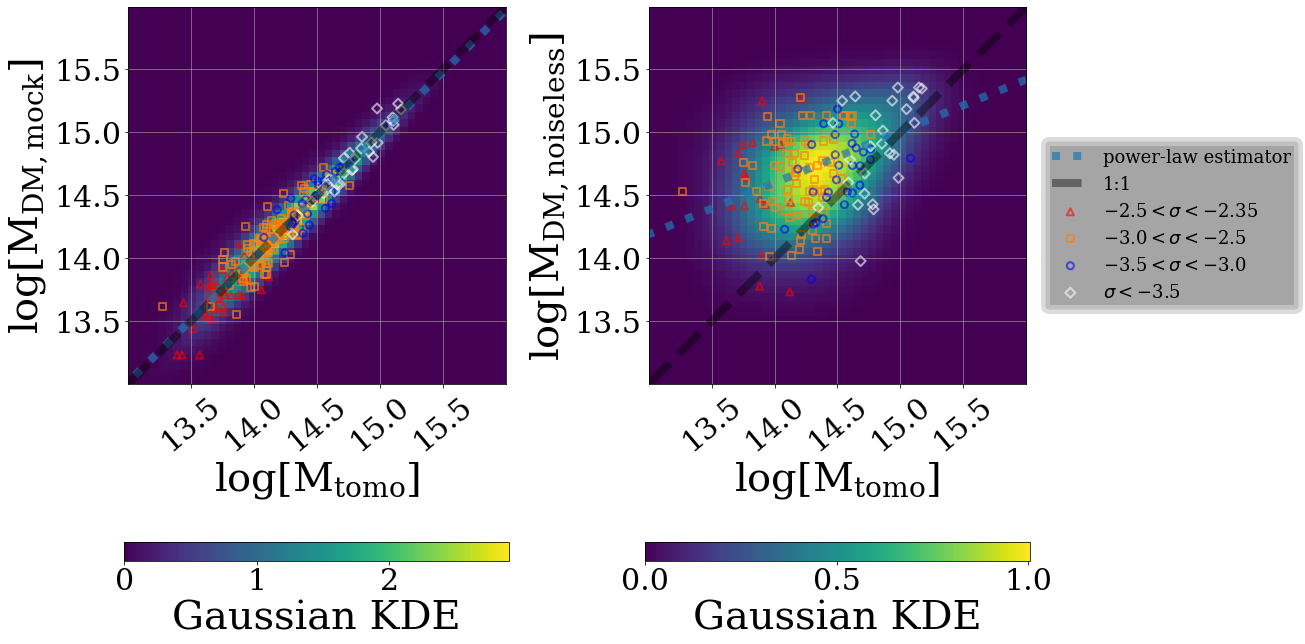

In [74]:
fig = plot_for_paper(n=1, z=2.6, th=2.35, lc=2.00, co=(0.41,14.60), vmin=0.2, vmax=1, conversion_not_adjusted=False)
fig = plot_for_paper(n=1, z=2.6, th=2.35, lc=2.00, co=(0.41,14.60), vmin=0.2, vmax=1, conversion_not_adjusted=True)

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3|  | 0.43+-0.09 | 14.54+-0.06|
|2.4|  | 0.39+-0.07 | 14.54+-0.04|
|2.6|  | 0.35+-0.05 | 14.58+-0.03|

- We found the estimators for $M_{DM}$-vs-$M_{tomo}$ realtion and the scatter around them.

- Our estimator and the scatter around it is not changed whether we use the same $\delta_F$-vs-$\rho_{DM}$ estimator or not. So, we can use the mid-redshift parameters for the entire map.

In [this notebook](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/M0_Mtomo.ipynb), we show the estimators for $M_{desc}$-vs-$M_{tomo}$ stays the same too.